In [1]:
import numpy as np
from pywave.energy_transport.energy_transfer_2dirns_manager import EnergyTransfer2DirnsManager

# Anisotropic scattering

## Implicit solver
- No dissipation
- Use smaller time step

In [2]:
et2d = EnergyTransfer2DirnsManager.from_config('config_files/aniso_implicit.cfg', verbose=True)

Options from config file:
{
    "dx": 1.0,
    "dt": 0.1,
    "nx": 200,
    "nt": 30000,
    "alpha": 0.05,
    "gamma": 0.0,
    "cg": 0.9,
    "aniso": true,
    "scheme": "lax_wendroff",
    "limiter": "superbee",
    "u_correction_scheme": "implicit",
    "neumann": false,
    "u_in": 1.0,
    "output_interval": 50,
    "outdir": "out_aniso_implicit",
    "figdir": "figs_aniso_implicit"
}


In [3]:
# check steady solution
s = slice(101, 121)
print(
    et2d.u_steady[s], 
    np.exp((- 2 * et2d.alpha[s] / et2d.cg[s]) * np.arange(20) * et2d.dx),
    sep='\n'
)

[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]
[1.         0.89483932 0.8007374  0.71653131 0.64118039 0.57375342
 0.51341712 0.45942582 0.41111229 0.36787944 0.32919299 0.29457483
 0.26359714 0.23587708 0.21107209 0.1888756  0.16901332 0.15123976
 0.13533528 0.12110333]


In [4]:
et2d.run()

Saving out_aniso_implicit/et2d_00000.npz
Saving out_aniso_implicit/et2d_00050.npz
Saving out_aniso_implicit/et2d_00100.npz
Saving out_aniso_implicit/et2d_00150.npz
Saving out_aniso_implicit/et2d_00200.npz
Saving out_aniso_implicit/et2d_00250.npz
Saving out_aniso_implicit/et2d_00300.npz
Saving out_aniso_implicit/et2d_00350.npz
Saving out_aniso_implicit/et2d_00400.npz
Saving out_aniso_implicit/et2d_00450.npz
Saving out_aniso_implicit/et2d_00500.npz
Saving out_aniso_implicit/et2d_00550.npz
Saving out_aniso_implicit/et2d_00600.npz
Saving out_aniso_implicit/et2d_00650.npz
Saving out_aniso_implicit/et2d_00700.npz
Saving out_aniso_implicit/et2d_00750.npz
Saving out_aniso_implicit/et2d_00800.npz
Saving out_aniso_implicit/et2d_00850.npz
Saving out_aniso_implicit/et2d_00900.npz
Saving out_aniso_implicit/et2d_00950.npz
Saving out_aniso_implicit/et2d_01000.npz
Saving out_aniso_implicit/et2d_01050.npz
Saving out_aniso_implicit/et2d_01100.npz
Saving out_aniso_implicit/et2d_01150.npz
Saving out_aniso

Saving out_aniso_implicit/et2d_10100.npz
Saving out_aniso_implicit/et2d_10150.npz
Saving out_aniso_implicit/et2d_10200.npz
Saving out_aniso_implicit/et2d_10250.npz
Saving out_aniso_implicit/et2d_10300.npz
Saving out_aniso_implicit/et2d_10350.npz
Saving out_aniso_implicit/et2d_10400.npz
Saving out_aniso_implicit/et2d_10450.npz
Saving out_aniso_implicit/et2d_10500.npz
Saving out_aniso_implicit/et2d_10550.npz
Saving out_aniso_implicit/et2d_10600.npz
Saving out_aniso_implicit/et2d_10650.npz
Saving out_aniso_implicit/et2d_10700.npz
Saving out_aniso_implicit/et2d_10750.npz
Saving out_aniso_implicit/et2d_10800.npz
Saving out_aniso_implicit/et2d_10850.npz
Saving out_aniso_implicit/et2d_10900.npz
Saving out_aniso_implicit/et2d_10950.npz
Saving out_aniso_implicit/et2d_11000.npz
Saving out_aniso_implicit/et2d_11050.npz
Saving out_aniso_implicit/et2d_11100.npz
Saving out_aniso_implicit/et2d_11150.npz
Saving out_aniso_implicit/et2d_11200.npz
Saving out_aniso_implicit/et2d_11250.npz
Saving out_aniso

Saving out_aniso_implicit/et2d_20450.npz
Saving out_aniso_implicit/et2d_20500.npz
Saving out_aniso_implicit/et2d_20550.npz
Saving out_aniso_implicit/et2d_20600.npz
Saving out_aniso_implicit/et2d_20650.npz
Saving out_aniso_implicit/et2d_20700.npz
Saving out_aniso_implicit/et2d_20750.npz
Saving out_aniso_implicit/et2d_20800.npz
Saving out_aniso_implicit/et2d_20850.npz
Saving out_aniso_implicit/et2d_20900.npz
Saving out_aniso_implicit/et2d_20950.npz
Saving out_aniso_implicit/et2d_21000.npz
Saving out_aniso_implicit/et2d_21050.npz
Saving out_aniso_implicit/et2d_21100.npz
Saving out_aniso_implicit/et2d_21150.npz
Saving out_aniso_implicit/et2d_21200.npz
Saving out_aniso_implicit/et2d_21250.npz
Saving out_aniso_implicit/et2d_21300.npz
Saving out_aniso_implicit/et2d_21350.npz
Saving out_aniso_implicit/et2d_21400.npz
Saving out_aniso_implicit/et2d_21450.npz
Saving out_aniso_implicit/et2d_21500.npz
Saving out_aniso_implicit/et2d_21550.npz
Saving out_aniso_implicit/et2d_21600.npz
Saving out_aniso

Saving figs_aniso_implicit/et2d_00000.png
Saving figs_aniso_implicit/et2d_00050.png
Saving figs_aniso_implicit/et2d_00100.png
Saving figs_aniso_implicit/et2d_00150.png
Saving figs_aniso_implicit/et2d_00200.png
Saving figs_aniso_implicit/et2d_00250.png
Saving figs_aniso_implicit/et2d_00300.png
Saving figs_aniso_implicit/et2d_00350.png
Saving figs_aniso_implicit/et2d_00400.png
Saving figs_aniso_implicit/et2d_00450.png
Saving figs_aniso_implicit/et2d_00500.png
Saving figs_aniso_implicit/et2d_00550.png
Saving figs_aniso_implicit/et2d_00600.png
Saving figs_aniso_implicit/et2d_00650.png
Saving figs_aniso_implicit/et2d_00700.png
Saving figs_aniso_implicit/et2d_00750.png
Saving figs_aniso_implicit/et2d_00800.png
Saving figs_aniso_implicit/et2d_00850.png
Saving figs_aniso_implicit/et2d_00900.png
Saving figs_aniso_implicit/et2d_00950.png
Saving figs_aniso_implicit/et2d_01000.png
Saving figs_aniso_implicit/et2d_01050.png
Saving figs_aniso_implicit/et2d_01100.png
Saving figs_aniso_implicit/et2d_01

Saving figs_aniso_implicit/et2d_09800.png
Saving figs_aniso_implicit/et2d_09850.png
Saving figs_aniso_implicit/et2d_09900.png
Saving figs_aniso_implicit/et2d_09950.png
Saving figs_aniso_implicit/et2d_10000.png
Saving figs_aniso_implicit/et2d_10050.png
Saving figs_aniso_implicit/et2d_10100.png
Saving figs_aniso_implicit/et2d_10150.png
Saving figs_aniso_implicit/et2d_10200.png
Saving figs_aniso_implicit/et2d_10250.png
Saving figs_aniso_implicit/et2d_10300.png
Saving figs_aniso_implicit/et2d_10350.png
Saving figs_aniso_implicit/et2d_10400.png
Saving figs_aniso_implicit/et2d_10450.png
Saving figs_aniso_implicit/et2d_10500.png
Saving figs_aniso_implicit/et2d_10550.png
Saving figs_aniso_implicit/et2d_10600.png
Saving figs_aniso_implicit/et2d_10650.png
Saving figs_aniso_implicit/et2d_10700.png
Saving figs_aniso_implicit/et2d_10750.png
Saving figs_aniso_implicit/et2d_10800.png
Saving figs_aniso_implicit/et2d_10850.png
Saving figs_aniso_implicit/et2d_10900.png
Saving figs_aniso_implicit/et2d_10

Saving figs_aniso_implicit/et2d_19600.png
Saving figs_aniso_implicit/et2d_19650.png
Saving figs_aniso_implicit/et2d_19700.png
Saving figs_aniso_implicit/et2d_19750.png
Saving figs_aniso_implicit/et2d_19800.png
Saving figs_aniso_implicit/et2d_19850.png
Saving figs_aniso_implicit/et2d_19900.png
Saving figs_aniso_implicit/et2d_19950.png
Saving figs_aniso_implicit/et2d_20000.png
Saving figs_aniso_implicit/et2d_20050.png
Saving figs_aniso_implicit/et2d_20100.png
Saving figs_aniso_implicit/et2d_20150.png
Saving figs_aniso_implicit/et2d_20200.png
Saving figs_aniso_implicit/et2d_20250.png
Saving figs_aniso_implicit/et2d_20300.png
Saving figs_aniso_implicit/et2d_20350.png
Saving figs_aniso_implicit/et2d_20400.png
Saving figs_aniso_implicit/et2d_20450.png
Saving figs_aniso_implicit/et2d_20500.png
Saving figs_aniso_implicit/et2d_20550.png
Saving figs_aniso_implicit/et2d_20600.png
Saving figs_aniso_implicit/et2d_20650.png
Saving figs_aniso_implicit/et2d_20700.png
Saving figs_aniso_implicit/et2d_20

Saving figs_aniso_implicit/et2d_29400.png
Saving figs_aniso_implicit/et2d_29450.png
Saving figs_aniso_implicit/et2d_29500.png
Saving figs_aniso_implicit/et2d_29550.png
Saving figs_aniso_implicit/et2d_29600.png
Saving figs_aniso_implicit/et2d_29650.png
Saving figs_aniso_implicit/et2d_29700.png
Saving figs_aniso_implicit/et2d_29750.png
Saving figs_aniso_implicit/et2d_29800.png
Saving figs_aniso_implicit/et2d_29850.png
Saving figs_aniso_implicit/et2d_29900.png
Saving figs_aniso_implicit/et2d_29950.png
Saving figs_aniso_implicit/et2d_30000.png


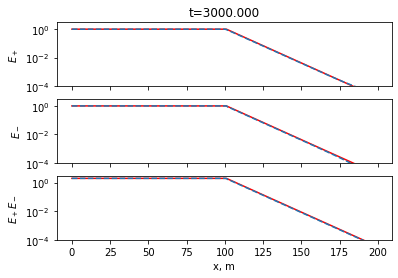

In [5]:
et2d.plot_steps()

## Use split-step solver
- add small amount of dissipation so we can use larger time step

In [6]:
et2d = EnergyTransfer2DirnsManager.from_config('config_files/aniso_split.cfg', verbose=True)

Options from config file:
{
    "dx": 1.0,
    "dt": 1.0,
    "nx": 200,
    "nt": 3000,
    "alpha": 0.05,
    "gamma": 5e-07,
    "cg": 0.9,
    "aniso": true,
    "scheme": "lax_wendroff",
    "limiter": "superbee",
    "u_correction_scheme": "split_step",
    "neumann": false,
    "u_in": 1.0,
    "output_interval": 5,
    "outdir": "out_aniso_split_step",
    "figdir": "figs_aniso_split_step"
}


In [7]:
et2d.run()

Saving out_aniso_split_step/et2d_00000.npz
Saving out_aniso_split_step/et2d_00005.npz
Saving out_aniso_split_step/et2d_00010.npz
Saving out_aniso_split_step/et2d_00015.npz
Saving out_aniso_split_step/et2d_00020.npz
Saving out_aniso_split_step/et2d_00025.npz
Saving out_aniso_split_step/et2d_00030.npz
Saving out_aniso_split_step/et2d_00035.npz
Saving out_aniso_split_step/et2d_00040.npz
Saving out_aniso_split_step/et2d_00045.npz
Saving out_aniso_split_step/et2d_00050.npz
Saving out_aniso_split_step/et2d_00055.npz
Saving out_aniso_split_step/et2d_00060.npz
Saving out_aniso_split_step/et2d_00065.npz
Saving out_aniso_split_step/et2d_00070.npz
Saving out_aniso_split_step/et2d_00075.npz
Saving out_aniso_split_step/et2d_00080.npz
Saving out_aniso_split_step/et2d_00085.npz
Saving out_aniso_split_step/et2d_00090.npz
Saving out_aniso_split_step/et2d_00095.npz
Saving out_aniso_split_step/et2d_00100.npz
Saving out_aniso_split_step/et2d_00105.npz
Saving out_aniso_split_step/et2d_00110.npz
Saving out_

Saving out_aniso_split_step/et2d_00975.npz
Saving out_aniso_split_step/et2d_00980.npz
Saving out_aniso_split_step/et2d_00985.npz
Saving out_aniso_split_step/et2d_00990.npz
Saving out_aniso_split_step/et2d_00995.npz
Saving out_aniso_split_step/et2d_01000.npz
Saving out_aniso_split_step/et2d_01005.npz
Saving out_aniso_split_step/et2d_01010.npz
Saving out_aniso_split_step/et2d_01015.npz
Saving out_aniso_split_step/et2d_01020.npz
Saving out_aniso_split_step/et2d_01025.npz
Saving out_aniso_split_step/et2d_01030.npz
Saving out_aniso_split_step/et2d_01035.npz
Saving out_aniso_split_step/et2d_01040.npz
Saving out_aniso_split_step/et2d_01045.npz
Saving out_aniso_split_step/et2d_01050.npz
Saving out_aniso_split_step/et2d_01055.npz
Saving out_aniso_split_step/et2d_01060.npz
Saving out_aniso_split_step/et2d_01065.npz
Saving out_aniso_split_step/et2d_01070.npz
Saving out_aniso_split_step/et2d_01075.npz
Saving out_aniso_split_step/et2d_01080.npz
Saving out_aniso_split_step/et2d_01085.npz
Saving out_

Saving out_aniso_split_step/et2d_01930.npz
Saving out_aniso_split_step/et2d_01935.npz
Saving out_aniso_split_step/et2d_01940.npz
Saving out_aniso_split_step/et2d_01945.npz
Saving out_aniso_split_step/et2d_01950.npz
Saving out_aniso_split_step/et2d_01955.npz
Saving out_aniso_split_step/et2d_01960.npz
Saving out_aniso_split_step/et2d_01965.npz
Saving out_aniso_split_step/et2d_01970.npz
Saving out_aniso_split_step/et2d_01975.npz
Saving out_aniso_split_step/et2d_01980.npz
Saving out_aniso_split_step/et2d_01985.npz
Saving out_aniso_split_step/et2d_01990.npz
Saving out_aniso_split_step/et2d_01995.npz
Saving out_aniso_split_step/et2d_02000.npz
Saving out_aniso_split_step/et2d_02005.npz
Saving out_aniso_split_step/et2d_02010.npz
Saving out_aniso_split_step/et2d_02015.npz
Saving out_aniso_split_step/et2d_02020.npz
Saving out_aniso_split_step/et2d_02025.npz
Saving out_aniso_split_step/et2d_02030.npz
Saving out_aniso_split_step/et2d_02035.npz
Saving out_aniso_split_step/et2d_02040.npz
Saving out_

Saving out_aniso_split_step/et2d_02885.npz
Saving out_aniso_split_step/et2d_02890.npz
Saving out_aniso_split_step/et2d_02895.npz
Saving out_aniso_split_step/et2d_02900.npz
Saving out_aniso_split_step/et2d_02905.npz
Saving out_aniso_split_step/et2d_02910.npz
Saving out_aniso_split_step/et2d_02915.npz
Saving out_aniso_split_step/et2d_02920.npz
Saving out_aniso_split_step/et2d_02925.npz
Saving out_aniso_split_step/et2d_02930.npz
Saving out_aniso_split_step/et2d_02935.npz
Saving out_aniso_split_step/et2d_02940.npz
Saving out_aniso_split_step/et2d_02945.npz
Saving out_aniso_split_step/et2d_02950.npz
Saving out_aniso_split_step/et2d_02955.npz
Saving out_aniso_split_step/et2d_02960.npz
Saving out_aniso_split_step/et2d_02965.npz
Saving out_aniso_split_step/et2d_02970.npz
Saving out_aniso_split_step/et2d_02975.npz
Saving out_aniso_split_step/et2d_02980.npz
Saving out_aniso_split_step/et2d_02985.npz
Saving out_aniso_split_step/et2d_02990.npz
Saving out_aniso_split_step/et2d_02995.npz
Saving out_

Saving figs_aniso_split_step/et2d_00000.png
Saving figs_aniso_split_step/et2d_00005.png
Saving figs_aniso_split_step/et2d_00010.png
Saving figs_aniso_split_step/et2d_00015.png
Saving figs_aniso_split_step/et2d_00020.png
Saving figs_aniso_split_step/et2d_00025.png
Saving figs_aniso_split_step/et2d_00030.png
Saving figs_aniso_split_step/et2d_00035.png
Saving figs_aniso_split_step/et2d_00040.png
Saving figs_aniso_split_step/et2d_00045.png
Saving figs_aniso_split_step/et2d_00050.png
Saving figs_aniso_split_step/et2d_00055.png
Saving figs_aniso_split_step/et2d_00060.png
Saving figs_aniso_split_step/et2d_00065.png
Saving figs_aniso_split_step/et2d_00070.png
Saving figs_aniso_split_step/et2d_00075.png
Saving figs_aniso_split_step/et2d_00080.png
Saving figs_aniso_split_step/et2d_00085.png
Saving figs_aniso_split_step/et2d_00090.png
Saving figs_aniso_split_step/et2d_00095.png
Saving figs_aniso_split_step/et2d_00100.png
Saving figs_aniso_split_step/et2d_00105.png
Saving figs_aniso_split_step/et2

Saving figs_aniso_split_step/et2d_00935.png
Saving figs_aniso_split_step/et2d_00940.png
Saving figs_aniso_split_step/et2d_00945.png
Saving figs_aniso_split_step/et2d_00950.png
Saving figs_aniso_split_step/et2d_00955.png
Saving figs_aniso_split_step/et2d_00960.png
Saving figs_aniso_split_step/et2d_00965.png
Saving figs_aniso_split_step/et2d_00970.png
Saving figs_aniso_split_step/et2d_00975.png
Saving figs_aniso_split_step/et2d_00980.png
Saving figs_aniso_split_step/et2d_00985.png
Saving figs_aniso_split_step/et2d_00990.png
Saving figs_aniso_split_step/et2d_00995.png
Saving figs_aniso_split_step/et2d_01000.png
Saving figs_aniso_split_step/et2d_01005.png
Saving figs_aniso_split_step/et2d_01010.png
Saving figs_aniso_split_step/et2d_01015.png
Saving figs_aniso_split_step/et2d_01020.png
Saving figs_aniso_split_step/et2d_01025.png
Saving figs_aniso_split_step/et2d_01030.png
Saving figs_aniso_split_step/et2d_01035.png
Saving figs_aniso_split_step/et2d_01040.png
Saving figs_aniso_split_step/et2

Saving figs_aniso_split_step/et2d_01870.png
Saving figs_aniso_split_step/et2d_01875.png
Saving figs_aniso_split_step/et2d_01880.png
Saving figs_aniso_split_step/et2d_01885.png
Saving figs_aniso_split_step/et2d_01890.png
Saving figs_aniso_split_step/et2d_01895.png
Saving figs_aniso_split_step/et2d_01900.png
Saving figs_aniso_split_step/et2d_01905.png
Saving figs_aniso_split_step/et2d_01910.png
Saving figs_aniso_split_step/et2d_01915.png
Saving figs_aniso_split_step/et2d_01920.png
Saving figs_aniso_split_step/et2d_01925.png
Saving figs_aniso_split_step/et2d_01930.png
Saving figs_aniso_split_step/et2d_01935.png
Saving figs_aniso_split_step/et2d_01940.png
Saving figs_aniso_split_step/et2d_01945.png
Saving figs_aniso_split_step/et2d_01950.png
Saving figs_aniso_split_step/et2d_01955.png
Saving figs_aniso_split_step/et2d_01960.png
Saving figs_aniso_split_step/et2d_01965.png
Saving figs_aniso_split_step/et2d_01970.png
Saving figs_aniso_split_step/et2d_01975.png
Saving figs_aniso_split_step/et2

Saving figs_aniso_split_step/et2d_02805.png
Saving figs_aniso_split_step/et2d_02810.png
Saving figs_aniso_split_step/et2d_02815.png
Saving figs_aniso_split_step/et2d_02820.png
Saving figs_aniso_split_step/et2d_02825.png
Saving figs_aniso_split_step/et2d_02830.png
Saving figs_aniso_split_step/et2d_02835.png
Saving figs_aniso_split_step/et2d_02840.png
Saving figs_aniso_split_step/et2d_02845.png
Saving figs_aniso_split_step/et2d_02850.png
Saving figs_aniso_split_step/et2d_02855.png
Saving figs_aniso_split_step/et2d_02860.png
Saving figs_aniso_split_step/et2d_02865.png
Saving figs_aniso_split_step/et2d_02870.png
Saving figs_aniso_split_step/et2d_02875.png
Saving figs_aniso_split_step/et2d_02880.png
Saving figs_aniso_split_step/et2d_02885.png
Saving figs_aniso_split_step/et2d_02890.png
Saving figs_aniso_split_step/et2d_02895.png
Saving figs_aniso_split_step/et2d_02900.png
Saving figs_aniso_split_step/et2d_02905.png
Saving figs_aniso_split_step/et2d_02910.png
Saving figs_aniso_split_step/et2

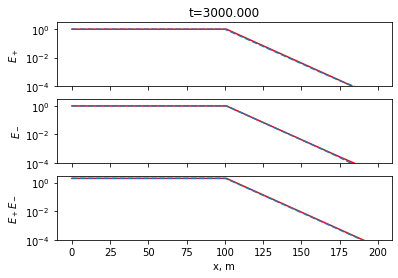

In [8]:
et2d.plot_steps()

# Isotropic scattering
- no dissipation
- split step solver with larger time step

In [9]:
et2d = EnergyTransfer2DirnsManager.from_config('config_files/iso_split.cfg', verbose=True)

Options from config file:
{
    "dx": 1.0,
    "dt": 1.0,
    "nx": 200,
    "nt": 1000,
    "alpha": 0.05,
    "gamma": 0.0,
    "cg": 0.9,
    "aniso": false,
    "scheme": "lax_wendroff",
    "limiter": "superbee",
    "u_correction_scheme": "split_step",
    "neumann": false,
    "u_in": 1.0,
    "output_interval": 5,
    "outdir": "out_iso_split_step",
    "figdir": "figs_iso_split_step"
}


In [10]:
et2d.run()

Saving out_iso_split_step/et2d_00000.npz
Saving out_iso_split_step/et2d_00005.npz
Saving out_iso_split_step/et2d_00010.npz
Saving out_iso_split_step/et2d_00015.npz
Saving out_iso_split_step/et2d_00020.npz
Saving out_iso_split_step/et2d_00025.npz
Saving out_iso_split_step/et2d_00030.npz
Saving out_iso_split_step/et2d_00035.npz
Saving out_iso_split_step/et2d_00040.npz
Saving out_iso_split_step/et2d_00045.npz
Saving out_iso_split_step/et2d_00050.npz
Saving out_iso_split_step/et2d_00055.npz
Saving out_iso_split_step/et2d_00060.npz
Saving out_iso_split_step/et2d_00065.npz
Saving out_iso_split_step/et2d_00070.npz
Saving out_iso_split_step/et2d_00075.npz
Saving out_iso_split_step/et2d_00080.npz
Saving out_iso_split_step/et2d_00085.npz
Saving out_iso_split_step/et2d_00090.npz
Saving out_iso_split_step/et2d_00095.npz
Saving out_iso_split_step/et2d_00100.npz
Saving out_iso_split_step/et2d_00105.npz
Saving out_iso_split_step/et2d_00110.npz
Saving out_iso_split_step/et2d_00115.npz
Saving out_iso_s

Saving figs_iso_split_step/et2d_00000.png
Saving figs_iso_split_step/et2d_00000.png
Saving figs_iso_split_step/et2d_00005.png
Saving figs_iso_split_step/et2d_00010.png
Saving figs_iso_split_step/et2d_00015.png
Saving figs_iso_split_step/et2d_00020.png
Saving figs_iso_split_step/et2d_00025.png
Saving figs_iso_split_step/et2d_00030.png
Saving figs_iso_split_step/et2d_00035.png
Saving figs_iso_split_step/et2d_00040.png
Saving figs_iso_split_step/et2d_00045.png
Saving figs_iso_split_step/et2d_00050.png
Saving figs_iso_split_step/et2d_00055.png
Saving figs_iso_split_step/et2d_00060.png
Saving figs_iso_split_step/et2d_00065.png
Saving figs_iso_split_step/et2d_00070.png
Saving figs_iso_split_step/et2d_00075.png
Saving figs_iso_split_step/et2d_00080.png
Saving figs_iso_split_step/et2d_00085.png
Saving figs_iso_split_step/et2d_00090.png
Saving figs_iso_split_step/et2d_00095.png
Saving figs_iso_split_step/et2d_00100.png
Saving figs_iso_split_step/et2d_00105.png
Saving figs_iso_split_step/et2d_00

Saving figs_iso_split_step/et2d_00970.png
Saving figs_iso_split_step/et2d_00975.png
Saving figs_iso_split_step/et2d_00980.png
Saving figs_iso_split_step/et2d_00985.png
Saving figs_iso_split_step/et2d_00990.png
Saving figs_iso_split_step/et2d_00995.png
Saving figs_iso_split_step/et2d_00010.png
Saving figs_iso_split_step/et2d_01000.png
Saving figs_iso_split_step/et2d_00015.png
Saving figs_iso_split_step/et2d_00020.png
Saving figs_iso_split_step/et2d_00025.png
Saving figs_iso_split_step/et2d_00030.png
Saving figs_iso_split_step/et2d_00035.png
Saving figs_iso_split_step/et2d_00040.png
Saving figs_iso_split_step/et2d_00045.png
Saving figs_iso_split_step/et2d_00050.png
Saving figs_iso_split_step/et2d_00055.png
Saving figs_iso_split_step/et2d_00060.png
Saving figs_iso_split_step/et2d_00065.png
Saving figs_iso_split_step/et2d_00070.png
Saving figs_iso_split_step/et2d_00075.png
Saving figs_iso_split_step/et2d_00080.png
Saving figs_iso_split_step/et2d_00085.png
Saving figs_iso_split_step/et2d_00

Saving figs_iso_split_step/et2d_00950.png
Saving figs_iso_split_step/et2d_00955.png
Saving figs_iso_split_step/et2d_00960.png
Saving figs_iso_split_step/et2d_00965.png
Saving figs_iso_split_step/et2d_00970.png
Saving figs_iso_split_step/et2d_00975.png
Saving figs_iso_split_step/et2d_00980.png
Saving figs_iso_split_step/et2d_00985.png
Saving figs_iso_split_step/et2d_00990.png
Saving figs_iso_split_step/et2d_00995.png


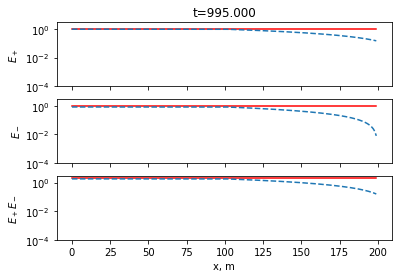

In [11]:
et2d.plot_steps()